<a href="https://colab.research.google.com/github/meganluu/BIOEN437/blob/main/Megan_Luu_FinalSoftwareProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q tellurium
!pip install -q SBstoat
!pip install numpy --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import tellurium as te
import numpy as np
import pandas as pd
import SBstoat
import matplotlib.pyplot as plt
from SBstoat.modelFitter import ModelFitter
import itertools
import sklearn.metrics
import collections
import seaborn as sns

# Model Introduction
For my software project, I used the curated BioModels model from https://www.ebi.ac.uk/biomodels/BIOMD0000000366#Overview (full article: https://www.sciencedirect.com/science/article/pii/S0022247X08005581?via%3Dihub). This model shows the dynamics of proteins involved in blood coagulation, including various coagulation factors, prothrombin, and thrombin. The reaction mechanisms included in the model are pictured in the diagram below. The study conducted in the paper focused on studying the effects of introducing blood anti-coagulants into the system, and in my new study, I plan to further study how the dynamics of thrombin can be altered.

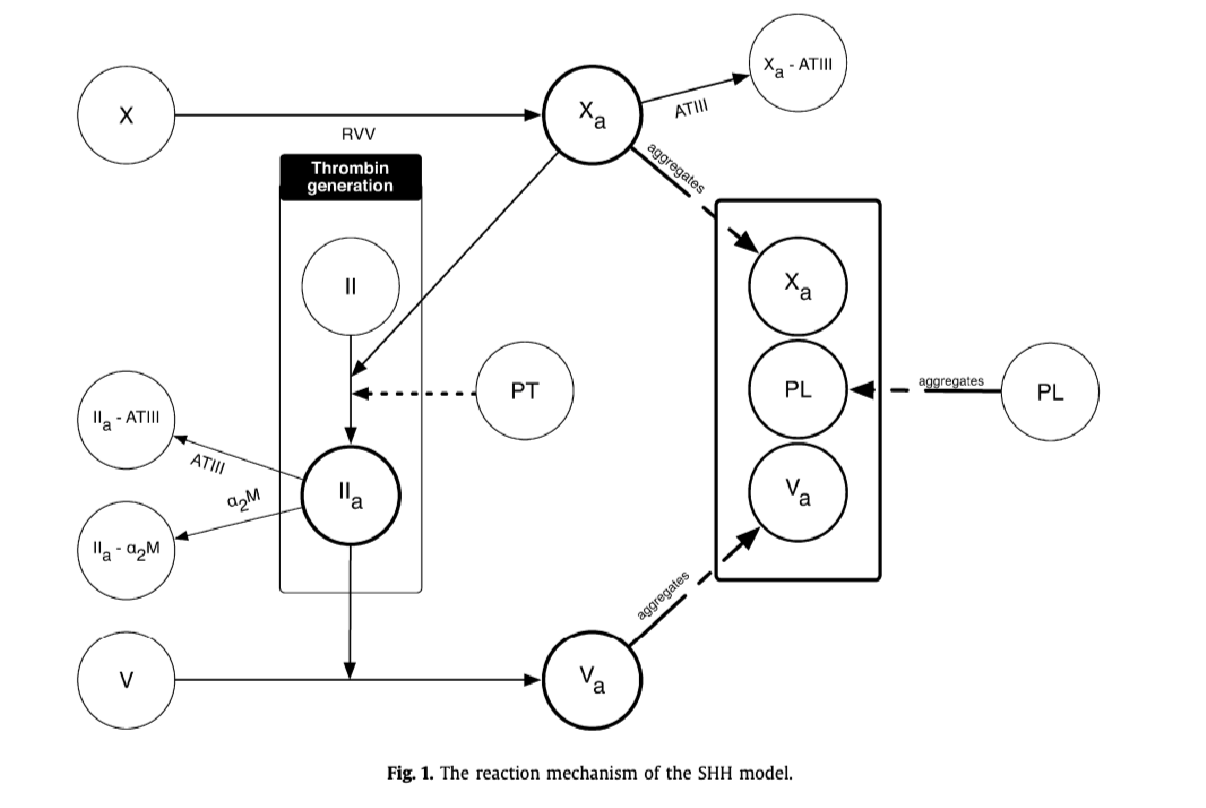

In [ ]:
# Load the model
MODEL = te.loadSBMLModel('https://www.ebi.ac.uk/biomodels/model/download/BIOMD0000000366.2?filename=BIOMD0000000366_url.xml')
print(MODEL.getAntimony())

// Created by libAntimony v2.13.2
function HenriMichaelisMenten_irreversible_kcat(kcat, enzyme, substrate, Km)
  kcat*enzyme*substrate/(Km + substrate);
end

HenriMichaelisMenten_irreversible_kcat is "Henri-Michaelis-Menten (irreversible) kcat"


model *Model_1()

  // Compartments and Species:
  compartment compartment_1;
  species X in compartment_1, Xa in compartment_1, Xa_ATIII in compartment_1;
  species PL in compartment_1, PT in compartment_1, Va in compartment_1, IIa in compartment_1;
  species V in compartment_1, II in compartment_1, IIa_alpha2M in compartment_1;
  species IIa_ATIII in compartment_1, RVV in compartment_1;

  // Assignment Rules:
  AmAct := IIa + 0.556*IIa_alpha2M;

  // Reactions:
  R1: X => Xa; compartment_1*HenriMichaelisMenten_irreversible_kcat(kcat_X, RVV, X, km_X);
  R2: Xa => Xa_ATIII; compartment_1*ki_Xa*Xa;
  R3: Va + Xa + PL -> PT; compartment_1*(k_PT*Va*Xa*PL - k_PL*PT);
  R4: V => Va; compartment_1*HenriMichaelisMenten_irreversible_kcat(kcat_V, IIa,

#Helper Functions

In [ ]:
TEST_MODEL = """
A->B; A
B->; k*B; 
A = 10; 
B=0
k = 2
"""
TEST_MODEL_RR = te.loada(TEST_MODEL)
TEST_MODEL_ARR = TEST_MODEL_RR.simulate()
TEST_MODEL_TS = SBstoat.NamedTimeseries(array=TEST_MODEL_ARR, colnames=TEST_MODEL_ARR.colnames)

In [ ]:
def arrToDF(arr):
    """
    Converts a NamedArray into a DataFrame.
    If it is simulation output, makes TIME the index.

    Parameters
    ----------
    arr: NamedArray
    
    Returns
    -------
    DataFrame
        Removes "[" , "]" from the names of species
    """
    columns = [c[1:-1] if c[0] == "[" else c for c in arr.colnames]
    df = pd.DataFrame(arr, columns=columns)
    df = df.set_index("time")
    return df

# Tests
assert(isinstance(arrToDF(TEST_MODEL_ARR), pd.DataFrame))
print("OK!")

OK!


In [ ]:
def arrToTS(arr):
    """
    Converts NamedArray to a NamedTimeseries
    
    Parameters
    ----------
    arr: NamedArray
    
    Returns
    -------
    NamedTimeseries
    """
    return SBstoat.NamedTimeseries(array=arr, colnames=arr.colnames)

# Tests
assert(isinstance(arrToTS(TEST_MODEL_ARR), SBstoat.NamedTimeseries))
print("OK!")

OK!


In [ ]:
def getParameterValueDct(model):
    """
    Finds the name and value of all parameters.
    
    Parameters
    ----------
    model: str (Antimony model)
    
    Returns
    -------
    dict (key: str, value: float)
    """
    rr = te.loada(model)
    return {n: rr[n] for n in rr.model.getGlobalParameterIds()}

# Tests
dct = getParameterValueDct(TEST_MODEL)
assert(isinstance(dct, dict))
assert("k" in dct.keys())
print("OK!")

OK!


# Reanalysis of Model
- Generate synthetic data for the model with different standard deviations. If your paper has experimental data, then you’ll be adding various levels of noise to the experimental data. If the paper does not have experimental data, then you will generate synthetic data as we have done in class.
- Calculate the model $R^2$ and parameter variances for the different standard deviations. Use this to assess the robustness of the model to variability in the data.

## Reanalysis Functions

In [ ]:
def generateNoisyData(model, std):
  '''
  Generates synthetic data for model with noise of specified standard deviation.

  Parameters
  -----------
  model: RoadRunner object
  std: float

  Returns
  ----------
  synthetic_data: STstoat.NamedTimeseries
  '''
  model.resetAll()
  sim_data = model.simulate(0, 30, 500)
  synthetic_data = arrToTS(sim_data)
  for species in synthetic_data.colnames:
    scale = np.mean(synthetic_data[species])
    synthetic_data[species] += scale*np.random.normal(0, std, len(synthetic_data))
  return synthetic_data

# Tests
test = generateNoisyData(MODEL, 0.1)
assert(isinstance(test, SBstoat.namedTimeseries.NamedTimeseries))
#assert((test['IIa'][1] - generateNoisyData(MODEL, 0)['IIa'][1]) != 0)
print('OK!')

OK!


In [ ]:
def getParameters(param_dict, lower_frc, start_frc, upper_frc):
  '''
  Takes in dictionary of parameter names and values, percentages of parameter's
  true value to assign as upper limit, lower limit, and starting value.

  Parameters
  -----------
  param_dict: dictionary
  lower_frc: float
  upper_frc: float
  start_frc: float

  Returns
  -----------
  parameters: list of SBstoat.Parameter
  '''
  parameters = []
  for param in param_dict:
    name = param
    lower = lower_frc*param_dict[param]
    upper = upper_frc*param_dict[param]
    start_val = start_frc*param_dict[param]
    result = SBstoat.Parameter(name, lower, upper, start_val)
    parameters.append(result)
  return parameters

#Tests
dct = getParameterValueDct(MODEL.getAntimony())
assert(isinstance(getParameters(dct, 0.5, 0.5, 2.0), list))
assert(isinstance(getParameters(dct, 0.5, 0.5, 2.0)[0], SBstoat.Parameter))
print('OK!')

OK!


In [ ]:
def findCloseMatchingValues(longArr, shortArr):
    """
    Finds the indices in longArr that are closest to the values in shortArr.

    Parameters
    ----------
    longArr: np.array
    shortArr: np.arry

    Returns
    -------
    array-int
    """
    indices = []
    for val in shortArr:
        distances = (longArr - val)**2
        minDistance = np.min(distances)
        distancesLst = list(distances)
        idx = distancesLst.index(minDistance)
        indices.append(idx)
    return np.array(indices)

# TESTS
longArr = np.array(range(10))
shortArr = np.array([2.1, 2.9, 4.3])
indexArr = findCloseMatchingValues(longArr, shortArr)
expectedArr = [2, 3, 4]
assert(all([v1 == v2 for v1, v2 in zip(indexArr, expectedArr)]))
print('OK!')

OK!


In [ ]:
def runSimulation(simTime=30, numPoint=500, roadRunner=None,
                  parameterDct=None, model=MODEL):
    """
    Runs the simulation model for the parameters.
   
    Parameters
    ----------
    endTime: float
        End time for the simulation
    numPoints: int
        Number of points in the simulation
    roadRunner: ExtendedRoadRunner
    parameters: list-str
        
    Returns
    -------
    NamedArray
        results of simulation
    """
    if roadRunner is None:
        roadRunner = model
    else:
        roadRunner.reset()
    if parameterDct is not None:
        # Set the simulation constants for all parameters
        for name in parameterDct.keys():
            roadRunner[name] = parameterDct[name]
    return roadRunner.simulate (0, simTime, numPoint)

#Tests
numPoint = int(10*30)
fittedData = runSimulation(parameterDct={"km_2": 0.1}, numPoint=numPoint)
numCol = np.shape(fittedData)[1]
assert(np.size(fittedData) == numPoint*numCol)
print('OK!')

OK!


In [ ]:
def generateFolds(observedData, numFold):
    """
    Generates training and test data
    by alternating between folds
    
    Parameters:
    ----------
    observedData: np.array(N, M) or NamedTimeseries
    numFold: int
        number of pairs of testIndices and trainIndices
    
    Returns:
    --------
    array-tuple(array, array)    
       tuple(array, array) - is training and test data for a fold
    """
    if isinstance(observedData, SBstoat.NamedTimeseries):
        df = observedData.to_dataframe()
        df = df.reset_index()
        observedData = df.to_numpy()
    result = []
    numPoint, numCol = np.shape(observedData)
    indices = range(numPoint)
    for remainder in range(numFold):
        testIndices = np.array([n for n in indices if n % numFold == remainder])
        testData = observedData[testIndices, :]
        trainIndices = np.array(list(set(indices).difference(testIndices)))
        trainData = observedData[trainIndices, :]
        entry = (trainData, testData)
        result.append(entry)
    return result
  
#Tests
numFold = 3
observedData = generateNoisyData(MODEL, 0.1)
folds = generateFolds(observedData, numFold)
assert(len(folds) == numFold)
fold = folds[0]
trainData = fold[0]
testData = fold[1]
assert(len(observedData) == (len(trainData) + len(testData)))
print("OK!")

OK!


In [ ]:
def estimateParameters(model, colnames, parametersToFit, trainingData,
                 **fittingArgs):
    """
    Finds the parameters that fit the fold.

    Parameters
    ----------
    model: antimony/ExtendedRoadRunner
    colnames: list-str
        names of data columns
    trainingData: np.array
    fittingArgs: dict
        optional arguments for ModelFitter

    Returns
    -------
    dict
        key: parameter name
        value: parameter valuec
    """
    # Estimate the parameters
    observedTS = SBstoat.NamedTimeseries(colnames=colnames, array=trainingData)
    fitter = ModelFitter(modelSpecification=model,
                                    parametersToFit=parametersToFit,
                                    observedData=observedTS,
                                    **fittingArgs,
                                    )
    fitter.fitModel()
    return dict(fitter.params.valuesdict())

#Tests
testdata = MODEL.simulate(0, 30, 500)
parameterDct = estimateParameters(MODEL, testdata.colnames,
                                  [SBstoat.Parameter('km_2', lower=0.1, upper=1)],
                                  testdata,
                                fitterMethods=["leastsquares"])
assert(isinstance(parameterDct, dict))
print('OK!')

OK!


In [ ]:
def evaluateFold(model, parameterDct, testData):
    """
    Calculates the R-squared value for the fit of the predicted test data for
    the values of the model parameters that are provided.

    Parameters
    ----------
    model: antimony/ExtendedRoadRunner
    parameterDct: dict
        key: str (parameter name)
        value: float (parameter value)
    testData: np.array

    Returns
    -------
    float: R squared
    ModelFitter
    """
    endTime = 30
    numPoint = 500
    fittedData = runSimulation(simTime=endTime, numPoint=numPoint,
                                parameterDct=parameterDct,
                                roadRunner=model)
    # Find the time indices that correspond to the test data
    testTimes = testData[:, 0]
    fittedTimes = fittedData[:, 0]
    indices = findCloseMatchingValues(fittedTimes, testTimes)
    # Calculate residuals for the corresponding times
    indexArr = np.array(indices)
    fittedTestData = fittedData[indexArr, 1:]
    flatFittedTestData = fittedTestData.flatten()
    flatTestData = (testData[:, 1:]).flatten()
    residualsArr = flatTestData - flatFittedTestData
    rsq = 1 - np.var(residualsArr)/np.var(flatTestData)
    #
    return rsq

#Tests
MODEL.resetAll()
observedData = MODEL.simulate(0, 30, 500)
parameterDct = estimateParameters(MODEL, list(observedData.colnames),
                                  [SBstoat.Parameter('km_2', lower=0.1, upper=1)],
                                  observedData,
                                fitterMethods=["leastsquares"])
MODEL.resetAll()
rsq = evaluateFold(MODEL, parameterDct, MODEL.simulate(0, 30, 500))
assert(rsq > 0.7)
print('OK!')

OK!


In [ ]:
def crossValidate(model, observedData, parametersToFit, colnames, numFold,
                  **fitterArgs):
    """
    Performs cross validation on the model.

    Parameters
    ----------
    model: ExtendedRoadrunner
    observedData: NamedTimeseries
    parametersToFit: list-SBstoat.Parameter
    colnames: list-str
    numFold: int

    Results
    -------
    pd.DataFrame
        Index: fold
        Columns
            R2: R squared value
            values of parameters
    """
    folds = generateFolds(observedData, numFold)
    resultDct = {p.name: [] for p in parametersToFit}
    resultDct['rsq'] = []
    for fold in folds:
        parameterDct = estimateParameters(model, colnames, parametersToFit,
                   fold[0],
                   fitterMethods=["leastsquares"])
        rsq = evaluateFold(model, parameterDct, fold[1])
        resultDct['rsq'].append(rsq)
        for parameter in parametersToFit:
            resultDct[parameter.name].append(parameterDct[parameter.name])
    df = pd.DataFrame(resultDct)
    return df

#Tests
MODEL.resetAll()
observedData = SBstoat.NamedTimeseries(dataframe=arrToDF(MODEL.simulate(0, 30, 500)))
resultDF = crossValidate(MODEL, observedData,
                         [SBstoat.Parameter('km_2', lower=0.1, upper=1)],
                          ['time'] + list(observedData.colnames), 5,
                          fitterMethods=["leastsquares"])
trues = [q > 0.7 for q in resultDF['rsq']]
print('OK!')

OK!


## Reanalysis Results

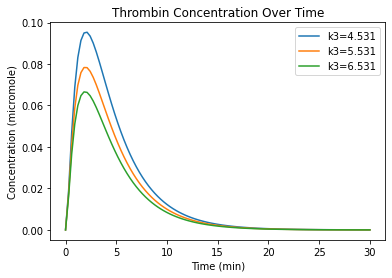

In [ ]:
# Reproduction of curated figure from BioModels
MODEL.resetAll()
base = MODEL.simulate(0, 30, 100, ['time', 'IIa'])
plt.plot(base['time'], base['IIa'], label='k3=4.531')
MODEL.resetAll()
MODEL['ki_Xa'] = 5.531
new1 = MODEL.simulate(0, 30, 100, ['time', 'IIa'])
plt.plot(new1['time'], new1['IIa'], label='k3=5.531')
MODEL.resetAll()
MODEL['ki_Xa'] = 6.531
new2 = MODEL.simulate(0, 30, 100, ['time', 'IIa'])
plt.plot(new2['time'], new2['IIa'], label='k3=6.531')
plt.legend()
plt.title('Thrombin Concentration Over Time')
plt.xlabel('Time (min)')
plt.ylabel('Concentration (micromole)')
plt.show()

In [ ]:
# Generate synthetic data with noise
dct = getParameterValueDct(MODEL.getAntimony())
dct.pop('AmAct')
parameters = getParameters(dct, 0.5, 0.5, 2.0)
SYNTHETICDATA = {}
for std in [0, 0.1, 0.3, 0.5, 1, 1.5, 2]:
  SYNTHETICDATA[std] = generateNoisyData(MODEL, std)

In [ ]:
colnames = ['time'] + SYNTHETICDATA[0].colnames
rsqs = []
params = ['kcat_X', 'km_X', 'ki_Xa', 'k_PT', 'kcat_V',
          'km_V', 'kcat_II', 'km_II', 'kcat_2', 'km_2', 'ki_IIaAlpha2M',
          'ki_IIaATIII']
param_vars = {param:[] for param in params}
for std in SYNTHETICDATA:
  df = crossValidate(MODEL, SYNTHETICDATA[std], parameters, colnames, 15)
  rsqs.append(df['rsq'].mean())
  vars = np.var(df.iloc[:, 0:-1])
  for param in params:
    param_vars[param].append(vars[param])

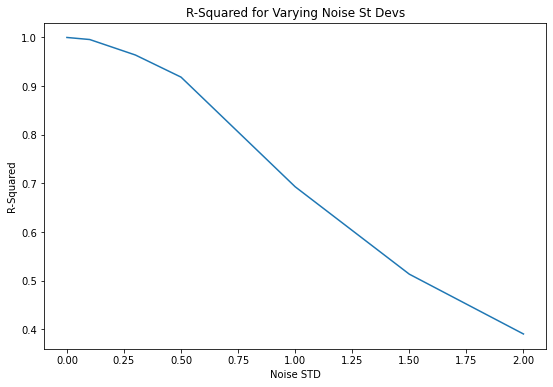

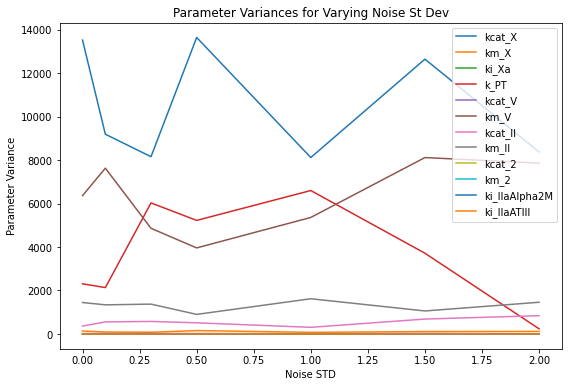

In [ ]:
plt.figure(figsize=(9,6))
plt.plot(list(SYNTHETICDATA.keys()), rsqs)
plt.title('R-Squared for Varying Noise St Devs')
plt.xlabel('Noise STD')
plt.ylabel('R-Squared')
plt.show()

plt.figure(figsize=(9,6))
for param in param_vars:
  plt.plot(list(SYNTHETICDATA.keys()), param_vars[param], label=param)
  plt.legend()
plt.xlabel('Noise STD')
plt.ylabel('Parameter Variance')
plt.title('Parameter Variances for Varying Noise St Dev')
plt.show()

Looking at the R-squared values for the synthetic data, the trends are as we expected - R-squared decreases as standard deviation of the noise increases. This makes sense because the model is being trained on noisier data, so the predicted parameters will be less able to accurately represent the variability in the data. Looking at the parameter variances, it appears that some parameters are more robust to data variability than others. Many of the parameters remain relatively stable, while others such as kcat_X, km_V, and k_PT fluctuate much more as STD changes.

# New Study Question

This is a text description of a new science or methodology question based on the paper. You should describe the problem, why you think it’s important, and an experimental design to study the problem.


Anticoagulants work by increasing the action of anti-thrombin (AT III). Translating this into the model, anticoagulants increase the rate constant associated with the deactivation of Factor X. The paper conducted a one-way study in which the value of this rate constant (ki_Xa) was altered to study its effects on thrombin concentrations over time. Seeing how this rate constant affects thrombin dynamics, I am now interested in seeing how changing two rate constants at a time affect thrombin dynamics. Specifically, I would like to study how these changes affect the maximal concentration of thrombin and the time it takes to reach this maximum. This question is of interest because it would inform us of which reactions we should target and how to alter them such that thrombin concentration is optimized (i.e.: reaches largest maximum in shortest amount of time for more efficient clotting). 
\
\
To study this problem, I will use 2-way design with specified levels of percent change for each rate constant within the model. The output will be a DataFrame with conditions that result in more efficient thrombin dynamics -- meaning thrombin reaches a maximum value quicker than baseline and that maximum value is larger than baseline. *This criteria can easily be altered depending on our interests - for example, output can show conditions in which thrombin reaches a maximal value slower than baseline instead. 

# Computational Study

This is a computational study of the new question. So, this section should include details of a simulation model you construct and output from it. Your study of the new question or methodology should draw on elements of the course such as: simulation technology, design of experiments, model accuracy, parameter estimation, and model validation. The elements here are analogous to what you did in parts of homework 2:
- Identify the factors and levels appropriate for your study
- Conduct the experiment, and provide visualizations to see interactions between factors.


# Study Functions

In [ ]:
def createLevels(levels):
  '''
  Creates dictionary of levels including each parameter

  Parameters
  -----------
  levels: list of percent change values to use to create levels

  Returns
  -----------
  dict where key is parameter name and value is list of floats containing
  levels for that parameter.
  '''
  level_dict = {param:[] for param in params}
  MODEL.resetAll()
  for param in params:
    base = MODEL[param]
    for level in levels:
      level_dict[param].append(base+(level*base))
  return level_dict

#Tests
test_dict = createLevels([-0.1, 0, 0.1])
assert(isinstance(test_dict, dict))
assert(isinstance(test_dict['km_V'], list))
print('OK!')

OK!


In [ ]:
def getMax(sim_data):
  '''
  Computes maximum thrombin and time maximum occurs for given simulation data.

  Parameters
  ------------
  sim_data: Named TimeSeries containing time and thrombin concentration data

  Returns
  ------------
  max_time: float
  max_conc: float
  '''
  idx = np.where(sim_data['IIa'] == max(sim_data['IIa']))
  max_row = sim_data[idx[0]]
  max_time = float(max_row['time'])
  max_conc = float(max_row['IIa'])
  return max_time, max_conc

#Tests
testdata = SYNTHETICDATA[0.1]
test_time, test_conc = getMax(testdata)
assert(isinstance(test_time, float))
assert(test_conc > 0)
assert(test_time > 0)
print('OK!')

OK!


In [ ]:
START_TIME = 0
END_TIME = 30
NUM_POINT = 100
LEVELS = [-0.3, -0.2, -0.1, 0, 0.1, 0.2, 0.3]
LEVELDICT = createLevels(LEVELS)

def runExperiment(model, factors, leveldict, isplot=False):
  '''
  Runs simulation of model for every combination of inputted factors at each level
  and optionally plots thrombin concentrations for each simulation. Returns each
  simulation result.

  Parameters
  ------------
  model: RoadRunner object
  factors: tuple of strings
  leveldict: dict of levels for each parameter
  isplot: boolean

  Returns
  ------------
  dict where keys are tuple representing levels for inputted factors and values
  are DataFrames of simulated data.
  '''
  result_dict = {}
  for level_a in leveldict[factors[0]]:
    for level_b in leveldict[factors[1]]:
      model.resetAll()
      model[factors[0]] = level_a
      model[factors[1]] = level_b 
      results = model.simulate(START_TIME, END_TIME, NUM_POINT, ['time', 'IIa'])
      result_dict[(level_a, level_b)] = arrToTS(results)
  # if isplot is True:
  #   plt.figure(figsize=(10,5))
  #   for level in result_dict:
  #     throm_results = result_dict[level]
  #     plt.plot(throm_results['time'], throm_results['IIa'])
  #     plt.legend(result_dict.keys())
  return result_dict

#Tests
test_result = runExperiment(MODEL, ('ki_Xa', 'km_2'), createLevels([0, 0.1]))
assert(isinstance(test_result, dict))
assert(isinstance(test_result[(4.531, 0.06148)], SBstoat.NamedTimeseries))
print('OK!')

OK!


In [ ]:
combos = list(itertools.combinations(LEVELDICT.keys(), 2))
def runStudy(model, combos, leveldict, baselinetime, baselineconc):
  '''
  Runs sets of simulations for two-way design with specified list of levels to use
  for study, prints experimental conditions that satisfy study criteria.

  Parameters
  ------------
  model: RoadRunner model
  combos: list of tuples
  levels: list of floats
  baselinetime: float
  baselineconc: float

  Returns
  -----------
  none
  '''
  factor1lst = []
  factor2lst = []
  level1lst = []
  level2lst = []
  max_timelist = []
  max_conclist = []
  for combo in combos:
    result_dict = runExperiment(model, combo, leveldict, isplot=False)
    for level_tuple in result_dict:
      sim_data = result_dict[level_tuple]
      max_time, max_conc = getMax(sim_data)
      if max_time < baselinetime and max_conc > baselineconc:
        factor1lst.append(combo[0])
        level1lst.append(level_tuple[0])
        factor2lst.append(combo[1])
        level2lst.append(level_tuple[1])
        max_timelist.append(max_time)
        max_conclist.append(max_conc)
  result = pd.DataFrame(list(zip(factor1lst, level1lst, factor2lst, level2lst, max_conclist, max_timelist)),
                        columns=['Factor 1', 'Value 1', 'Factor 2', 'Value 2', 'Max Thrombin Concentration', 'Max Time'])
  return result

#Tests
testcombos = [('kcat_X', 'km_X'), ('ki_IIaATIII', 'km_X')]
teststudy = runStudy(MODEL, testcombos, LEVELDICT, 2.12, 0.0954)
assert(isinstance(teststudy, pd.DataFrame))
assert(teststudy.columns[0] == 'Factor 1')
print('OK!')

OK!


In [ ]:
def createHeatmap(allresultdf, factor1, factor2, colorvar):
  '''
  Generates heatmap with specified factors and variable for color.

  Parameters
  ------------
  allresultdf: Pandas DataFrame
  factor1: str
  factor2: str
  colorvar: str

  Returns
  -----------
  None

  '''
  filtereddf = allresultdf[(allresultdf['Factor 1'] == factor1) & (allresultdf['Factor 2'] == factor2)]
  heatmapdata = filtereddf.pivot('Value 1', 'Value 2', colorvar)
  ax = sns.heatmap(heatmapdata)
  ax.set(xlabel=factor2, ylabel=factor1)
  plt.title(colorvar)
  plt.show()


# Study Results

In [ ]:
allresults = runStudy(MODEL, combos, LEVELDICT, 100, 0)
results = runStudy(MODEL, combos, LEVELDICT, 2.12, 0.0954)

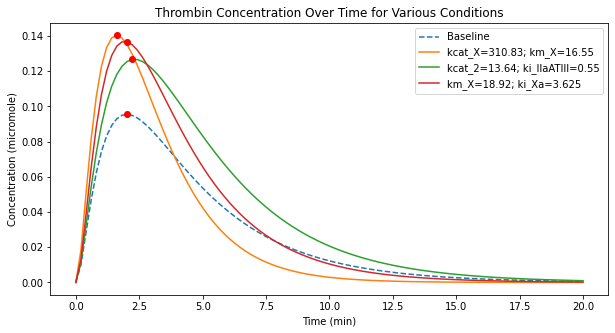

In [ ]:
MODEL.resetAll()
data1 = MODEL.simulate(0, 20, 100, ['time', 'IIa'])
plt.figure(figsize=(10,5))
plt.plot(data1['time'], data1['IIa'], '--', label='Baseline')
maxtime, maxconc = getMax(arrToTS(data1))
plt.plot(maxtime, maxconc, 'ro', label='_nolegend_')

MODEL.resetAll()
MODEL['kcat_X'] = 310.83
MODEL['km_X'] = 16.55
data2 = MODEL.simulate(0, 20, 100, ['time', 'IIa'])
plt.plot(data2['time'], data2['IIa'], label='kcat_X=310.83; km_X=16.55')
maxtime, maxconc = getMax(arrToTS(data2))
plt.plot(maxtime, maxconc, 'ro', label='_nolegend_')

MODEL.resetAll()
MODEL['kcat_2'] = 13.64
MODEL['ki_IIaATIII'] = 0.55
data3 = MODEL.simulate(0, 20, 100, ['time', 'IIa'])
plt.plot(data3['time'], data3['IIa'], label='kcat_2=13.64; ki_IIaATIII=0.55')
maxtime, maxconc = getMax(arrToTS(data3))
plt.plot(maxtime, maxconc, 'ro', label='_nolegend_')

MODEL.resetAll()
MODEL['km_X'] = 18.92
MODEL['ki_Xa'] = 3.625
data4 = MODEL.simulate(0, 20, 100, ['time', 'IIa'])
plt.plot(data4['time'], data4['IIa'], label='km_X=18.92; ki_Xa=3.625')
maxtime, maxconc = getMax(arrToTS(data4))
plt.plot(maxtime, maxconc, 'ro', label='_nolegend_')
plt.legend()
plt.title('Thrombin Concentration Over Time for Various Conditions')
plt.xlabel('Time (min)')
plt.ylabel('Concentration (micromole)')
plt.show()

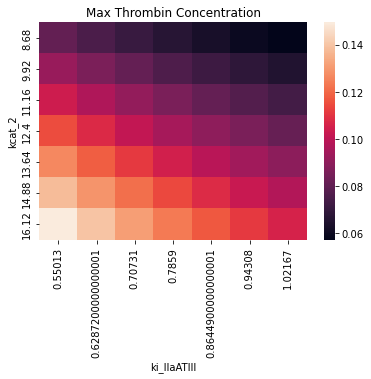

In [ ]:
createHeatmap(allresults, 'kcat_2', 'ki_IIaATIII', 'Max Thrombin Concentration')

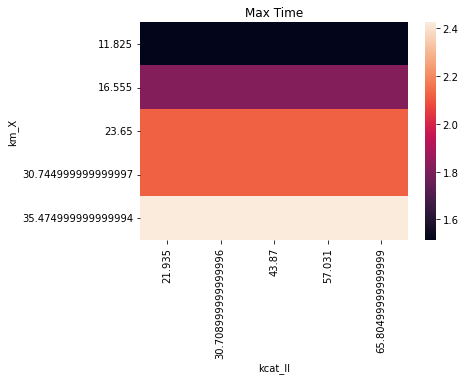

In [ ]:
newleveldict = createLevels([-0.5, -0.3, 0, 0.3, 0.5])
allresults = runStudy(MODEL, combos, newleveldict, 100, 0)
createHeatmap(allresults, 'km_X', 'kcat_II', 'Max Time')

# Discussion of Results

To recap, a 2-way design was utilized, so at most 2 factors were manipulated between the levels of -30% to +30% of their default baseline values to create different experimental conditions. The results of my computational study yielded 401 conditions in which thrombin concentration reached a maximum value larger than the baseline, and at an earlier time compared to baseline. After examining the results table and the plots, it appears that km_X especially influences the time it takes to reach maximal concentration (decreasing km_X decreases time to maximum) and kcat_2 & ki_IIaATIII influence the maximum concentration reached (increasing kcat_2 or decreasing ki_IIaATIII increases max). Knowing this, if we wanted to improve the speed of clotting, we can design drugs to target and decrease the rate of reaction R1, which will ultimately decrease the amount of time to reach maximum thrombin. Similarly, if we wanted to increase the maximal concentration of thrombin, we can design drugs to target the rates of reactions R6 or R8.